#### ResNet
[Deep Residual Learning for Image Recognition](resnet.pdf)

ResNet architecture makes use of shortcut connections to solve the vanishing gradient problem. The basic building block of ResNet is a Residual block that is repeated throughout the network.

Instead of learning the mapping from x →F(x), the network learns the mapping from x → F(x)+G(x). When the dimension of the input x and output F(x) is the same, the function G(x) = x is an identity function and the shortcut connection is called Identity connection. The identical mapping is learned by zeroing out the weights in the intermediate layer during training since it's easier to zero out the weights than push them to one.

For the case when the dimensions of F(x) differ from x (due to stride length>1 in the CONV layers in between), the Projection connection is implemented rather than the Identity connection. The function G(x) changes the dimensions of input x to that of output F(x). Two kinds of mapping were considered in the original paper.

- Non-trainable Mapping (Padding): The input x is simply padded with zeros to make the dimension match that of F(x)

- Trainable Mapping (Conv Layer): 1x1 Conv layer is used to map x to G(x). It can be seen from the table above that across the network the spatial dimensions are either kept the same or halved, and the depth is either kept the same or doubled and the product of Width and Depth after each conv layer remains the same i.e. 3584. 1x1 conv layers are used to half the spatial dimension and double the depth by using stride length of 2 and multiple of such filters respectively. The number of 1x1 conv layers is equal to the depth of F(x).

![image](resnet34.png)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader,random_split
from torchvision import transforms

def get_dataloaders(datasetname, batch_size, validation_fraction=0.2, train_transforms=transforms.ToTensor(), test_transforms=transforms.ToTensor()):
    # Load train and test datasets
    if datasetname == 'CIFAR10':
        train_dataset = datasets.CIFAR10(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.CIFAR10(root='data', train=False, transform=test_transforms)
    else: # MNIST
        train_dataset = datasets.MNIST(root='data', train=True, transform=train_transforms, download=True)
        test_dataset = datasets.MNIST(root='data', train=False, transform=test_transforms)

    # Split train dataset into train and validation subsets
    train_size = int((1 - validation_fraction) * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, valid_size])

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size, shuffle=True)
    valid_loader = DataLoader(val_subset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

def compute_accuracy(model, data_loader, device):
    with torch.no_grad():    
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()

        return correct_pred.float()/num_examples * 100

d:\Adams\Anaconda\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### SETTINGS
BATCH_SIZE = 256
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
set_seed(123)


### CIFAR10 DATASET
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((120, 120)),
    torchvision.transforms.RandomCrop((110, 110)),
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader, valid_loader, test_loader = get_dataloaders('CIFAR10', batch_size=BATCH_SIZE, validation_fraction=0.1, train_transforms=train_transforms, test_transforms=test_transforms)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 110, 110])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([2, 7, 4, 7, 0, 1, 1, 6, 9, 2])


##### ResNet Parameters
![image](resnet.png)

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):                   #[n, 3, 110, 110]
        x = F.relu(self.bn1(self.conv1(x))) #[n, 64, 55, 55]
        x = self.maxpool1(x)                #[n, 64, 28, 28]
        x = self.layer1(x)                  #[n, 64, 28, 28] 
        x = self.layer2(x)                  #[n, 128, 14, 14]
        x = self.layer3(x)                  #[n, 256, 7, 7]
        x = self.layer4(x)                  #[n, 512, 4, 4]
        x = self.avgpool(x)                 #[n, 512, 1, 1]
        x = x.view(x.size(0), -1)           #[n, 512]
        x = self.linear(x)                  #[n, 10]
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [4]:
#check if cuda available
print(torch.__version__)
print(torch.version.cuda)

import time
model = ResNet34()

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, mode='max', verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
start_time = time.time()

for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        # ## FORWARD AND BACK PROP
        logits = model(features)
        loss = torch.nn.functional.cross_entropy(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ## LOGGING
        minibatch_loss_list.append(loss.item())
        if not batch_idx % 100:
            print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}')

    model.eval()
    train_acc = compute_accuracy(model, train_loader, device=DEVICE)
    valid_acc = compute_accuracy(model, valid_loader, device=DEVICE)
    print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())
    
    scheduler.step(valid_acc_list[-1])

elapsed = (time.time() - start_time)/60
print(f'Time elapsed: {elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test accuracy {test_acc :.2f}%')

1.13.1
11.7
Epoch: 001/050 Batch 0000/0176 | Loss: 2.5301
Epoch: 001/050 Batch 0100/0176 | Loss: 2.0851
Epoch: 001/050 | Train: 33.29% | Validation: 31.86%
Epoch: 002/050 Batch 0000/0176 | Loss: 1.8989
Epoch: 002/050 Batch 0100/0176 | Loss: 1.6464
Epoch: 002/050 | Train: 43.69% | Validation: 41.94%
Epoch: 003/050 Batch 0000/0176 | Loss: 1.4504
Epoch: 003/050 Batch 0100/0176 | Loss: 1.3529
Epoch: 003/050 | Train: 52.63% | Validation: 50.38%
Epoch: 004/050 Batch 0000/0176 | Loss: 1.2340
Epoch: 004/050 Batch 0100/0176 | Loss: 1.2188
Epoch: 004/050 | Train: 58.91% | Validation: 57.04%
Epoch: 005/050 Batch 0000/0176 | Loss: 1.1897
Epoch: 005/050 Batch 0100/0176 | Loss: 1.1516
Epoch: 005/050 | Train: 63.35% | Validation: 61.24%
Epoch: 006/050 Batch 0000/0176 | Loss: 0.8594
Epoch: 006/050 Batch 0100/0176 | Loss: 0.9386
Epoch: 006/050 | Train: 68.67% | Validation: 65.16%
Epoch: 007/050 Batch 0000/0176 | Loss: 0.8284
Epoch: 007/050 Batch 0100/0176 | Loss: 0.7842
Epoch: 007/050 | Train: 72.61% |

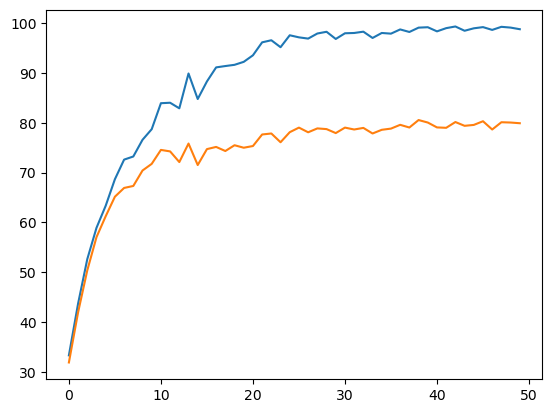

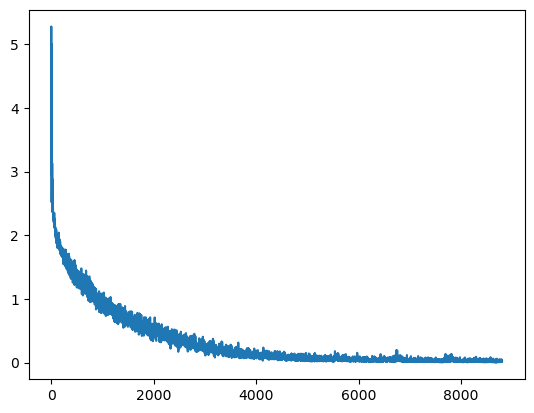

In [5]:
plt.plot(train_acc_list, label='train accuracy')
plt.plot(valid_acc_list, label='train accuracy')
plt.show()

plt.plot(minibatch_loss_list, label='loss')
plt.show()